# Gym Member Session Tracking

A detailed overview of gym members' exercise routines, physical attributes, and fitness metrics

_Source_: https://www.kaggle.com/datasets/valakhorasani/gym-members-exercise-dataset 

Group 18 Members:

- Clara Pichler, 11917694
- Hannah Knapp, 11901857 
- Sibel Toprakkiran, 09426341

### Overview

1. Introduction
- Requirements & Dependencies
- Loading in the Data Set

2. Preprocessing

3. Classification
- SVM
- Random Forest
- Multilayer Perceptron

4. Analysis of Performance

## Introduction 

### Requirements & Dependencies

This project was created using Python 3.12.5 The exact versions of the dependencies can be installed with the following command.

In [45]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from tpot import TPOTClassifier

In [47]:
df_gym = pd.read_csv('data/gym_members_exercise_tracking.csv')

## Preprocessing

In this section we will go over the pre processing of the data set. We take a look at the types of the attributes, outliers, normalisation/standardisation, feature selection and if the data set has missing values and if yes how do we deal with it accordingly. 

In [48]:
display(df_gym.head(5))
display(df_gym.info(verbose=True))
display(df_gym.describe())
display(df_gym['Workout_Type'].unique())

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

None

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
count,973.000000,973.000000,973.00000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000,973.000000
mean,38.683453,73.854676,1.72258,179.883864,143.766701,62.223022,1.256423,905.422405,24.976773,2.626619,3.321686,1.809866,24.912127
std,12.180928,21.207500,0.12772,11.525686,14.345101,7.327060,0.343033,272.641516,6.259419,0.600172,0.913047,0.739693,6.660879
min,18.000000,40.000000,1.50000,160.000000,120.000000,50.000000,0.500000,303.000000,10.000000,1.500000,2.000000,1.000000,12.320000
25%,28.000000,58.100000,1.62000,170.000000,131.000000,56.000000,1.040000,720.000000,21.300000,2.200000,3.000000,1.000000,20.110000
50%,40.000000,70.000000,1.71000,180.000000,143.000000,62.000000,1.260000,893.000000,26.200000,2.600000,3.000000,2.000000,24.160000
75%,49.000000,86.000000,1.80000,190.000000,156.000000,68.000000,1.460000,1076.000000,29.300000,3.100000,4.000000,2.000000,28.560000
max,59.000000,129.900000,2.00000,199.000000,169.000000,74.000000,2.000000,1783.000000,35.000000,3.700000,5.000000,3.000000,49.840000


array(['Yoga', 'HIIT', 'Cardio', 'Strength'], dtype=object)

We now use dummy variables for `Gender`and also our target `Workout_Type`. `Female` will be 0 and `Male` will be 1, as well as : `Yoga` = 0, `HIIT` = 1, `Cardio` = 2 and `Strength` = 3.

In [49]:
df_gym = df_gym.replace({
    "Yoga" : 0,
    "HIIT" : 1,
    "Cardio" : 2,
    "Strength" : 3,
    "Female" : 0,
    "Male": 0
    })

/var/folders/4j/v1g8gthx209g90f63vh1krc80000gn/T/ipykernel_40250/3802749717.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gym = df_gym.replace({


As for outlier detection we can look at them viusally through histograms, scatter plots or boxplots, we decided to stick to the Interquartile Range (IQR) and also look at the z-score as comparison. 

In [50]:
Q1_gym = df_gym.quantile(0.25)
Q3_gym = df_gym.quantile(0.75)
IQR_gym = Q3_gym - Q1_gym

IQR_outliers_gym = df_gym[((df_gym < (Q1_gym - 1.5 * IQR_gym)) | (df_gym > (Q3_gym + 1.5 * IQR_gym))).any(axis=1)]
# display(IQR_outliers_gym.info())

df_gym_IQR = df_gym[~((df_gym < (Q1_gym - 1.5 * IQR_gym)) | (df_gym > (Q3_gym + 1.5 * IQR_gym))).any(axis=1)].reset_index()
display(df_gym_IQR.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          932 non-null    int64  
 1   Age                            932 non-null    int64  
 2   Gender                         932 non-null    int64  
 3   Weight (kg)                    932 non-null    float64
 4   Height (m)                     932 non-null    float64
 5   Max_BPM                        932 non-null    int64  
 6   Avg_BPM                        932 non-null    int64  
 7   Resting_BPM                    932 non-null    int64  
 8   Session_Duration (hours)       932 non-null    float64
 9   Calories_Burned                932 non-null    float64
 10  Workout_Type                   932 non-null    int64  
 11  Fat_Percentage                 932 non-null    float64
 12  Water_Intake (liters)          932 non-null    flo

None

In [51]:
z_scores = stats.zscore(df_gym)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

df_gym_Z = df_gym[filtered_entries]
display(df_gym_Z.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            0 non-null      int64  
 1   Gender                         0 non-null      int64  
 2   Weight (kg)                    0 non-null      float64
 3   Height (m)                     0 non-null      float64
 4   Max_BPM                        0 non-null      int64  
 5   Avg_BPM                        0 non-null      int64  
 6   Resting_BPM                    0 non-null      int64  
 7   Session_Duration (hours)       0 non-null      float64
 8   Calories_Burned                0 non-null      float64
 9   Workout_Type                   0 non-null      int64  
 10  Fat_Percentage                 0 non-null      float64
 11  Water_Intake (liters)          0 non-null      float64
 12  Workout_Frequency (days/week)  0 non-null      int64  
 13  Experie

None

From looking at the distribution below, we decided to reduce the skewness of some attributes. This will be done after the splitting of the data set though. The following just shows the function we are using. We use MinMaxScaler for normalisation and StandardScaler vor standardisation. 

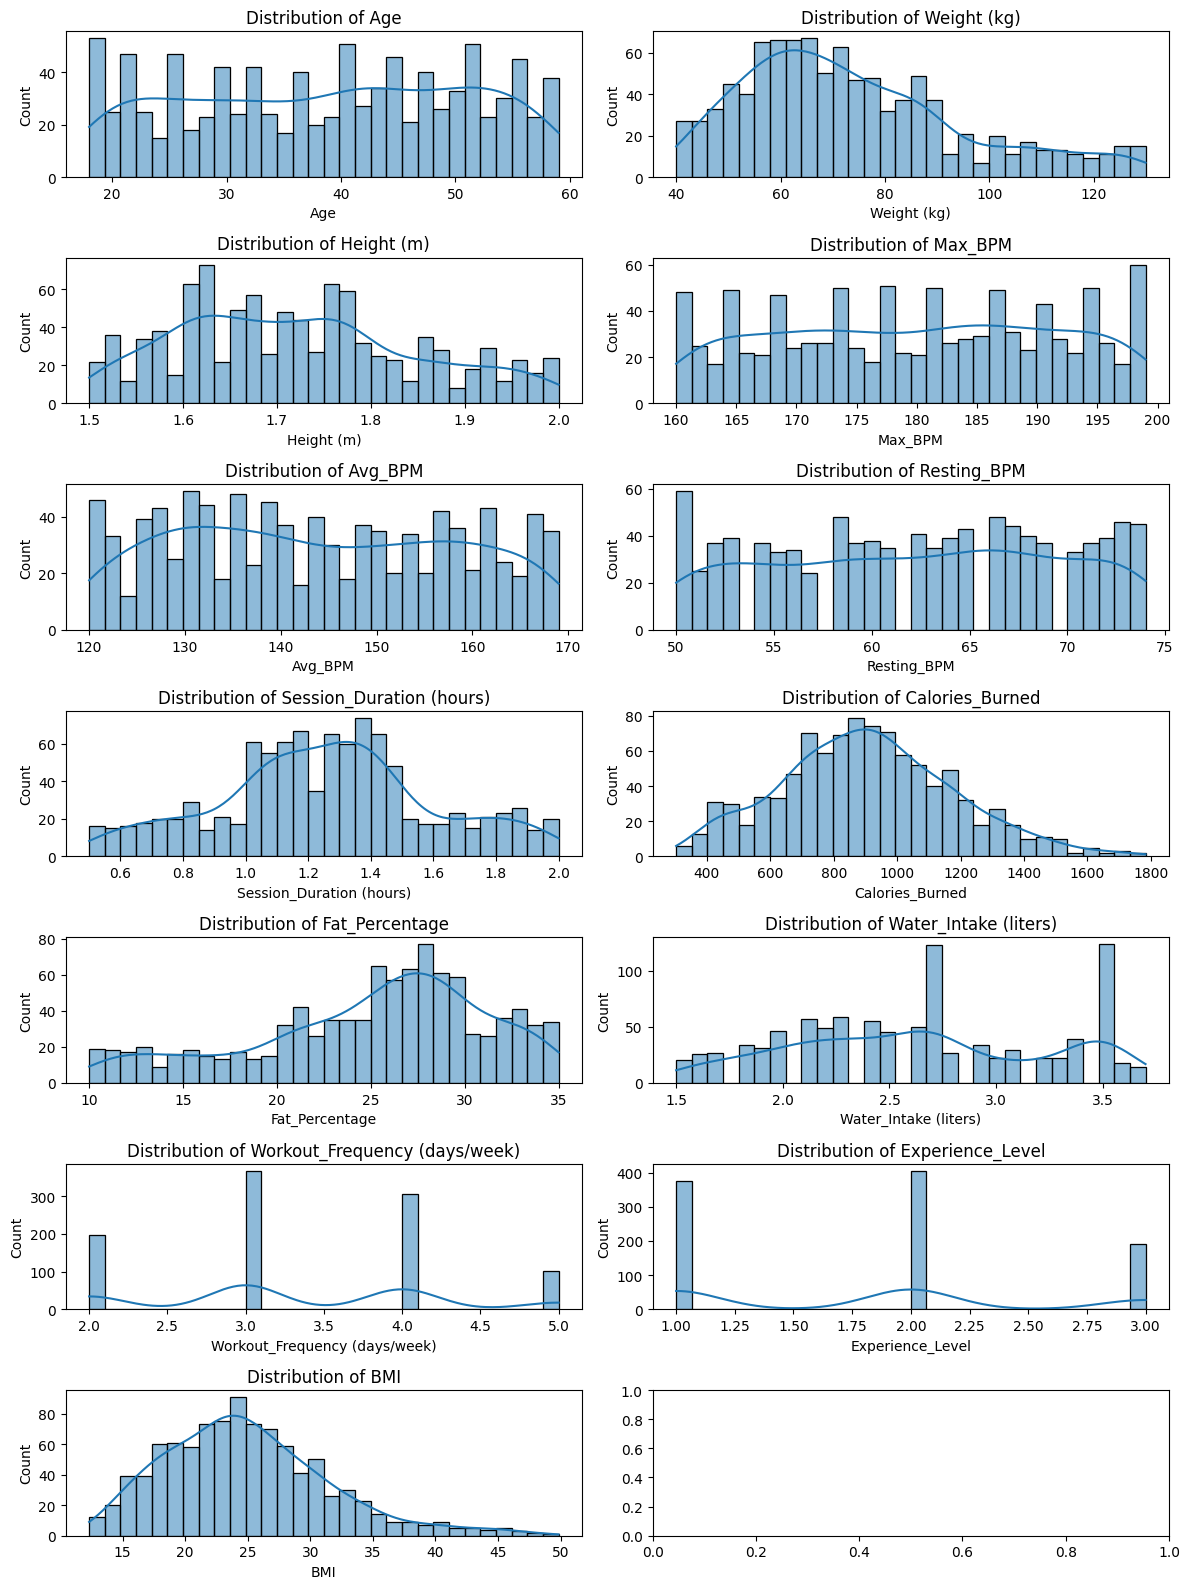

In [52]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 16))
axes = axes.flatten()

for i, column in enumerate(df_gym.drop(['Gender', 'Workout_Type'], axis=1).columns):  
    sns.histplot(df_gym[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    
plt.tight_layout()
plt.show()

In [60]:
def df_scaling(train, test, scaler):
    return scaler.fit_transform(train), scaler.transform(test)

For possible feature selection, we will look at the correlation of the attributes. The highest correlation has the column `Fat_Percentage` followed by `Avg_BPM`, but in general, none have a high correlation. Therefore we decided to use all of the features.

<Axes: >

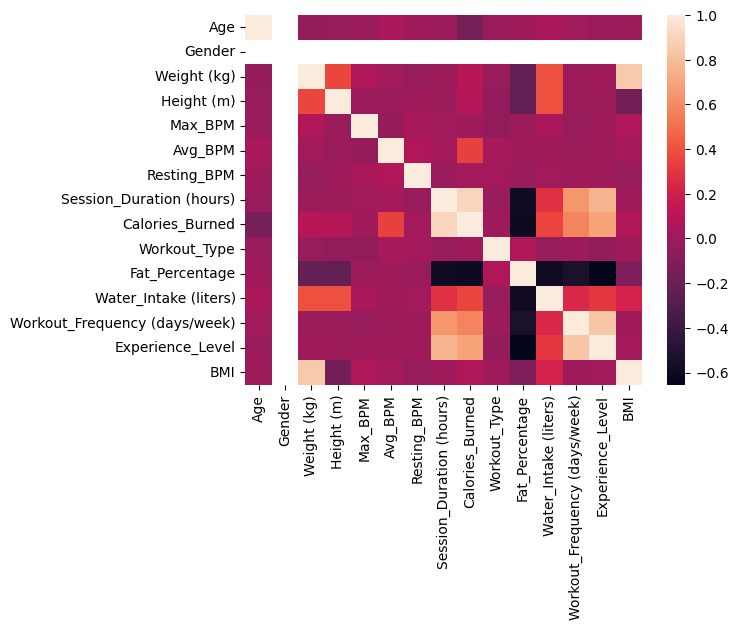

In [54]:
corrmat_gym = df_gym.corr(method='pearson', numeric_only=True)
sns.heatmap(corrmat_gym)

In [55]:
display(corrmat_gym[['Workout_Type']].sort_values('Workout_Type'))
display(corrmat_gym[['Calories_Burned']].sort_values('Calories_Burned'))

,Workout_Type
Max_BPM,-0.048874
Height (m),-0.048680
Experience_Level,-0.044232
Water_Intake (liters),-0.030963
Weight (kg),-0.026522
Session_Duration (hours),-0.023619
Age,-0.018926
Workout_Frequency (days/week),-0.011132
Calories_Burned,-0.006948
BMI,0.002226


,Calories_Burned
Fat_Percentage,-0.597615
Age,-0.154679
Workout_Type,-0.006948
Max_BPM,0.002090
Resting_BPM,0.016518
BMI,0.059761
Height (m),0.086348
Weight (kg),0.095443
Avg_BPM,0.339659
Water_Intake (liters),0.356931


In [56]:
display(df_gym.info())
display(df_gym_IQR.info())
display(df_gym_Z.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    int64  
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    int64  
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   index                          932 non-null    int64  
 1   Age                            932 non-null    int64  
 2   Gender                         932 non-null    int64  
 3   Weight (kg)                    932 non-null    float64
 4   Height (m)                     932 non-null    float64
 5   Max_BPM                        932 non-null    int64  
 6   Avg_BPM                        932 non-null    int64  
 7   Resting_BPM                    932 non-null    int64  
 8   Session_Duration (hours)       932 non-null    float64
 9   Calories_Burned                932 non-null    float64
 10  Workout_Type                   932 non-null    int64  
 11  Fat_Percentage                 932 non-null    float64
 12  Water_Intake (liters)          932 non-null    flo

None

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            0 non-null      int64  
 1   Gender                         0 non-null      int64  
 2   Weight (kg)                    0 non-null      float64
 3   Height (m)                     0 non-null      float64
 4   Max_BPM                        0 non-null      int64  
 5   Avg_BPM                        0 non-null      int64  
 6   Resting_BPM                    0 non-null      int64  
 7   Session_Duration (hours)       0 non-null      float64
 8   Calories_Burned                0 non-null      float64
 9   Workout_Type                   0 non-null      int64  
 10  Fat_Percentage                 0 non-null      float64
 11  Water_Intake (liters)          0 non-null      float64
 12  Workout_Frequency (days/week)  0 non-null      int64  
 13  Experie

None

## Classification - Workout Types

Our goal was always to classify the workout types of this data set, however, all models perform very badly. This can be because none of the other features are highly correlated with this column.
For training our classification models we will first have to split our data into training and testing data.

As well we define a function for all models that returns the confusion matrix and classification report.

In [66]:
def create_test_train(df):
    X_gym= df.drop('Workout_Type', axis=1)
    y_gym=df['Workout_Type']
    return train_test_split(X_gym,y_gym, random_state=104, test_size=0.25, shuffle=True, stratify=y_gym)

# X_gym_train, X_gym_test, y_gym_train, y_gym_test = create_test_train(df_gym)
# X_gym_train, X_gym_test, y_gym_train, y_gym_test = create_test_train(df_gym_Z)
X_gym_train, X_gym_test, y_gym_train, y_gym_test = create_test_train(df_gym_IQR)

In [67]:
def evaluate_classification(model, X_test, y_test):
    
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy * 100))
    print('Classification Report:')
    print(classification_report(y_test, predictions, zero_division=1))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    
    return accuracy

For scaling we use our function `df_scaling` which we have defined in the pre processing part. The difference between the two histograms are absurd.

<Axes: ylabel='Count'>

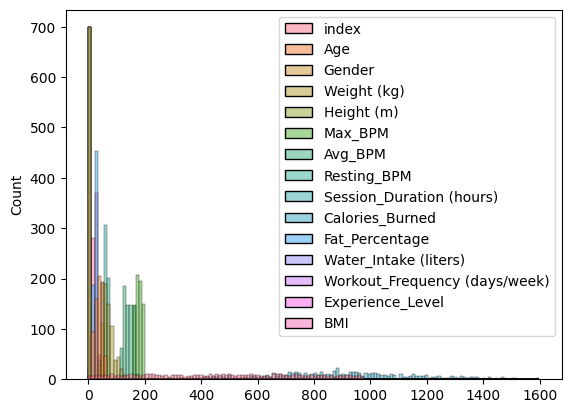

In [68]:
sns.histplot(X_gym_train)

In [69]:
# X_gym_train, X_gym_test = df_scaling(X_gym_test, X_gym_train, MinMaxScaler())
X_gym_train, X_gym_test = df_scaling(X_gym_train, X_gym_test, StandardScaler())

<Axes: ylabel='Count'>

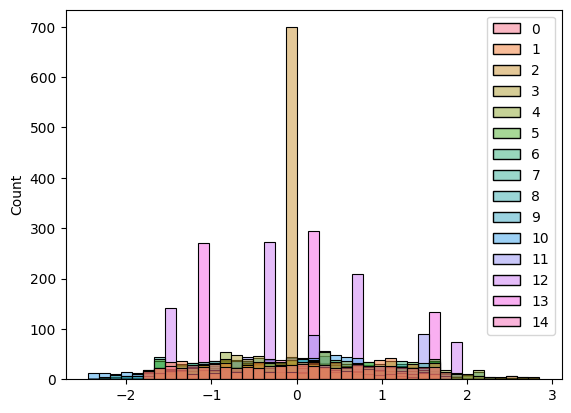

In [70]:
sns.histplot(X_gym_train)

### Support Vector Machines

Support Vector Machines transform the feature space into a higher-dimensional space to seperate classes. They have the advantages of being effective in high dimensional spaces and it is still effective in cases where number of dimensions is greater than the number of samples. It uses a subset of training points (support vectors) in the decision function, so it is also memory efficient.

First we will tune the hyperparameters using grid search and cross validation.

In [77]:
params_grid_svm = [
    {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 0.1, 1, 5], 'C': [1, 10, 100, 1000]},
    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
    {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 10, 100, 1000], 'degree': [2, 3, 4]}
]

svm_model = GridSearchCV(SVC(), params_grid_svm, cv=5)

Now to train our SVM model.

In [ ]:
svm_model.fit(X_gym_train, y_gym_train)

In [75]:
print("Best parameter: ", svm_model.best_params_,"\n")
print('Best score for training data:', svm_model.best_score_,"\n") 
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

best_model_svm = svm_model.best_estimator_

Best parameter:  {'C': 1, 'kernel': 'linear'} 

Best score for training data: 0.3069444444444444 

Best C: 1 

Best Kernel: linear 

Best Gamma: scale 



In [76]:
svm_gym_accuracy = evaluate_classification(svm_model, X_gym_test, y_gym_test)
svm_gym_accuracy_best = evaluate_classification(best_model_svm, X_gym_test, y_gym_test)

print('Improvement of {:0.2f}%.'.format( 100 * (svm_gym_accuracy_best - svm_gym_accuracy) / svm_gym_accuracy))

Model Performance
Accuracy = 21.67%.
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.08      0.11        59
           1       0.18      0.13      0.15        54
           2       0.24      0.37      0.29        63
           3       0.24      0.27      0.25        64

    accuracy                           0.22       240
   macro avg       0.20      0.21      0.20       240
weighted avg       0.20      0.22      0.20       240

Confusion Matrix:
[[ 5  9 24 21]
 [ 9  7 20 18]
 [ 9 15 23 16]
 [13  7 27 17]]
Model Performance
Accuracy = 21.67%.
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.08      0.11        59
           1       0.18      0.13      0.15        54
           2       0.24      0.37      0.29        63
           3       0.24      0.27      0.25        64

    accuracy                           0.22       240
   macro avg       0.20      0.21      0

### Random Forest

In [67]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_gym_train, y_gym_train)

RandomForestClassifier(random_state=42)

In [68]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['log2', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [69]:
rf_random = RandomizedSearchCV(RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

In [70]:
rf_random.fit(X_gym_train, y_gym_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42)

In [71]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_gym_train, y_gym_train)
base_accuracy = evaluate_classification(rf_model, X_gym_test, y_gym_test)
    
best_model_rf = rf_random.best_estimator_

random_accuracy = evaluate_classification(best_model_rf,X_gym_test, y_gym_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 25.75%.
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.33      0.30        58
           1       0.22      0.19      0.21        52
           2       0.27      0.26      0.26        61
           3       0.26      0.24      0.25        62

    accuracy                           0.26       233
   macro avg       0.25      0.26      0.25       233
weighted avg       0.26      0.26      0.26       233

Confusion Matrix:
[[19 13 16 10]
 [19 10 12 11]
 [14  9 16 22]
 [18 13 16 15]]
Model Performance
Accuracy = 26.18%.
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.36      0.32        58
           1       0.18      0.10      0.12        52
           2       0.27      0.28      0.27        61
           3       0.26      0.29      0.27        62

    accuracy                           0.26       233
   macro avg       0.25      0.26      0

### Multilayer Perceptron

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (10,20,20,25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'max_iter': [1500, 2000, 2500, 3000],
    'learning_rate': ['constant','adaptive'],
}

mlp_model = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=5, n_jobs=-1)
mlp_model.fit(X_gym_train, y_gym_train)

evaluate_classification(mlp_model, X_gym_test, y_gym_test)

In [ ]:
mlp_model.fit(X_gym_train, y_gym_train)

## Classification - Calories

Now will classify on the calories that were burned during the session.

For training our classification models we will first have to split our data into training and testing data.

In [ ]:
df_cal = df_gym.copy()
df_cal_IQR = df_gym_IQR.copy()
df_cal_Z = df_gym_Z.copy()
df_cal_scaled = df_gym_scaled.copy()
df_cal_Z_scaled = df_gym_Z_scaled.copy()
df_cal_selected = df_cal[['Session_Duration (hours)', 'Experience_Level', 'Calories_Burned', 'Workout_Frequency (days/week)', 'Water_Intake (liters)', 'Avg_BPM']].copy()


def categorize_cal(cals):
    if cals < 700:
        return 'Low'
    elif cals <= 1400:
        return 'Medium'
    else:
        return 'High'

df_cal['Calories_Burned'] = df_cal['Calories_Burned'].apply(categorize_cal)
df_cal_IQR['Calories_Burned'] = df_cal_IQR['Calories_Burned'].apply(categorize_cal)
df_cal_Z['Calories_Burned'] = df_cal_Z['Calories_Burned'].apply(categorize_cal)
df_cal_scaled['Calories_Burned'] = df_cal_scaled['Calories_Burned'].apply(categorize_cal)
df_cal_Z_scaled['Calories_Burned'] = df_cal_Z_scaled['Calories_Burned'].apply(categorize_cal)
df_cal_selected['Calories_Burned'] = df_cal_selected['Calories_Burned'].apply(categorize_cal)

In [ ]:
def create_test_train_cal(df):
    X_cal= df.drop('Calories_Burned', axis=1)
    y_cal=df['Calories_Burned']
    return train_test_split(X_cal,y_cal, random_state=104, test_size=0.25, shuffle=True, stratify=y_cal)

# X_cal_train, X_cal_test, y_cal_train, y_cal_test = create_test_train_cal(df_cal)
# X_cal_train, X_cal_test, y_cal_train, y_cal_test = create_test_train_cal(df_cal_Z)
X_cal_train, X_cal_test, y_cal_train, y_cal_test = create_test_train_cal(df_cal_IQR)
# X_cal_train, X_cal_test, y_cal_train, y_cal_test = create_test_train(df_cal_scaled)
# X_cal_train, X_cal_test, y_cal_train, y_cal_test = create_test_train(df_cal_Z_scaled)
# X_cal_train, X_cal_test, y_cal_train, y_cal_test = create_test_train(df_cal_selected_cal)

# TPOT

TPOT stands for Tree-based Pipeline Optimization Tool. TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

- feature selection
- feature preprocessing
- feature construction
- model selection
- parameter optimization

In [18]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=40)
tpot.fit(X_gym_train, y_gym_train)


Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.2746968139773895

Generation 2 - Current best internal CV score: 0.2875745118191161

Generation 3 - Current best internal CV score: 0.2875745118191161

Generation 4 - Current best internal CV score: 0.2875745118191161

Generation 5 - Current best internal CV score: 0.2875745118191161

Generation 6 - Current best internal CV score: 0.28896197327852

2.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: MultinomialNB(Normalizer(GaussianNB(input_matrix), norm=l2), alpha=1.0, fit_prior=True)


TPOTClassifier(max_eval_time_mins=0.04, max_time_mins=2, population_size=40,
               verbosity=2)

In [23]:
tpot.score(X_gym_test, y_gym_test)
tpot.export('tpot/tpot_gym_pipeline.py')

/Users/clarapichler/Documents/Projects/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/clarapichler/Documents/Projects/myenv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
